<a href="https://colab.research.google.com/github/kkdresen/masterds_thesis/blob/main/Thesis_Med_%26_Hugging_Face_EDA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Master Thesis

Datasets:
- medical dataset: https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions/data
- pii masking hugging face dataset: https://huggingface.co/datasets/ai4privacy/pii-masking-65k/viewer/default/train?row=2

Github:
- https://github.com/kkdresen/masterds_thesis

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=9ecab48eba10b7c80bde64c89ef2faf2370fd8b348c8247e2a28d111bd23a332
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


### Packages

In [ ]:
# Basic libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import random
import itertools
from collections import defaultdict

# Preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN



In [ ]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
# Models

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
import lightgbm as lgb

# Evaluation

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer


import warnings
warnings.filterwarnings("ignore")

In [ ]:
%matplotlib inline

### Load in Medical Data
* 4999 rows and 6 columns

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/00 UvA MASTER DATA SCIENCE /00. Thesis /Thesis Data/mtsamples.csv')
print(data.shape)
data.head()

(4999, 6)


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


### Missing Values

In [ ]:
def count_nan_values(data_frame, column_names):
    """
    Counts the number of NaN values in the specified column(s) of the given DataFrame.

    Parameters:
    - data_frame (pd.DataFrame): The DataFrame to analyze.
    - column_names (str or list): The name of the column or a list of column names to check for NaN values.

    Returns:
    - A dictionary with column names as keys and the count of NaN values as values. If a single column name is provided,
      a direct count is returned.
    """
    if isinstance(column_names, str):
        # If a single column name is provided, return the count directly
        return data_frame[column_names].isna().sum()
    elif isinstance(column_names, list):
        # If a list of column names is provided, return a dictionary with counts
        return {column: data_frame[column].isna().sum() for column in column_names}
    else:
        raise ValueError("The column_names parameter should be either a string or a list of strings.")

In [ ]:
count = count_nan_values(data, 'transcription')
print(f"Number of NaN values in 'column_name': {count}")

Number of NaN values in 'column_name': 33


In [ ]:
# to identify the null values by descending order
data.isnull().sum().sort_values(ascending = False)

keywords             1068
transcription          33
Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
dtype: int64

As there are 33 rows with NaN values in transcription these should be removed, as transcription is the sole column we focus on in the rest of the research

### Drop rows and columns

The dataset contains of several categories, but we will need only transcription, and medical_specialty, which is the target disgnostics type.

In [ ]:
data = data[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.head(2)

,transcription,medical_specialty
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics


## Data review

In [ ]:
data['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer

# Ensure NLTK resources are downloaded (only need to do this once)
nltk.download('punkt')

def get_sentence_word_count(transcriptions):
    sentence_count = sum(len(sent_tokenize(text)) for text in transcriptions)
    words = [word for text in transcriptions for word in word_tokenize(text)]
    unique_words = set(words)
    return sentence_count, len(unique_words)

# Filter out rows where 'transcription' is NaN
data = data[data['transcription'].notna()]

# Convert 'transcription' column to a list of strings for processing
transcriptions = data['transcription'].tolist()

# Get sentence and unique word counts
sent_count, word_count = get_sentence_word_count(transcriptions)

print("Number of sentences in transcriptions column: " + str(sent_count))
print("Number of unique words in transcriptions column: " + str(word_count))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of sentences in transcriptions column: 147028
Number of unique words in transcriptions column: 41910


In [ ]:
# Ensure NLTK resources are downloaded (only need to do this once)
nltk.download('punkt')

def analyze_transcription_metrics(transcription):
    # Tokenize the transcription into sentences and words
    sentences = sent_tokenize(transcription)
    words = word_tokenize(transcription)

    # Calculate metrics
    word_count = len(words)
    mean_word_length = sum(len(word) for word in words) / word_count
    mean_sentence_length = sum(len(sentence.split()) for sentence in sentences) / len(sentences)
    length_of_sample_review = len(transcription)  # Length of the sample review

    return {
        "Word count": word_count,
        "Mean word length": mean_word_length,
        "Mean sentence length": mean_sentence_length,
        "Length of sample review": length_of_sample_review,
        "Number of words in review": word_count,  # This is the same as word_count
        "Avg length of words": mean_word_length,  # This is the same as mean_word_length
        "Avg length of sentences in review": mean_sentence_length,  # Same as mean_sentence_length
    }

# Assuming 'data' is your DataFrame and it has a 'transcription' column
# Filter out rows where 'transcription' is NaN
data = data[data['transcription'].notna()]

# Apply the analysis to each transcription and create a new DataFrame with the results
metrics = data['transcription'].apply(analyze_transcription_metrics)
metrics_df = pd.DataFrame(metrics.tolist())

# Calculate mean, min, and max for each metric
metrics_summary = pd.DataFrame({
    "Mean": metrics_df.mean(),
    "Min": metrics_df.min(),
    "Max": metrics_df.max()
})

print(metrics_summary)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                          Mean    Min           Max
Word count                          553.022755   3.00   3489.000000
Mean word length                      4.649651   3.25      7.333333
Mean sentence length                 16.914368   1.00    114.000000
Length of sample review            3052.314337  11.00  18425.000000
Number of words in review           553.022755   3.00   3489.000000
Avg length of words                   4.649651   3.25      7.333333
Avg length of sentences in review    16.914368   1.00    114.000000


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.tokenize import RegexpTokenizer

# Ensure all entries in "transcription" are strings
data["transcription"] = data["transcription"].astype(str)

# Create a list of tokens for each sentence
tokenizer = RegexpTokenizer(r'\w+')
data["tokens"] = data["transcription"].apply(tokenizer.tokenize)

all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))


2420937 words total, with a vocabulary size of 28581
Max sentence length is 3114


In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

# Ensure NLTK resources are downloaded (only need to do this once)
nltk.download('punkt')

def calculate_corpus_statistics(data):
    total_sentences = 0
    total_words = 0

    for transcription in data['transcription']:
        # Tokenize the transcription into sentences and words
        sentences = sent_tokenize(transcription)
        words = word_tokenize(transcription)

        # Update total counts
        total_sentences += len(sentences)
        total_words += len(words)

    return total_sentences, total_words

# Assuming 'data' is your DataFrame and it has a 'transcription' column
# Filter out rows where 'transcription' is NaN
data = data[data['transcription'].notna()]

# Calculate total sentences and words in the corpus
total_sentences, total_words = calculate_corpus_statistics(data)

print(f"Total sentences in the corpus: {total_sentences}")
print(f"Total words in the corpus: {total_words}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Total sentences in the corpus: 147028
Total words in the corpus: 2746311


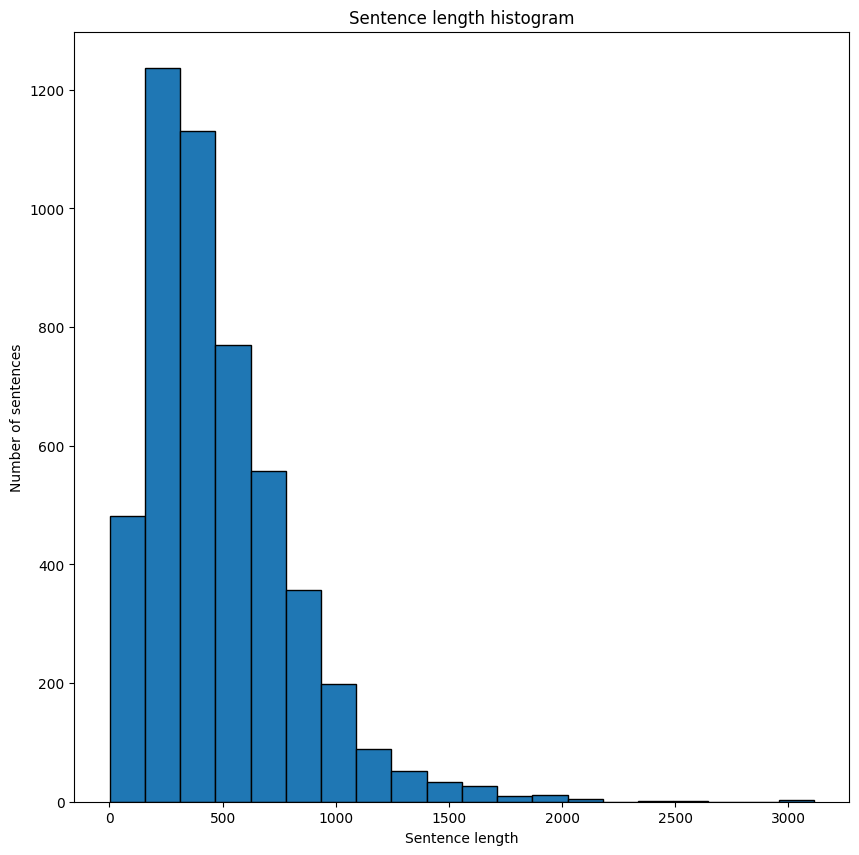

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.title('Sentence length histogram')
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths, edgecolor = 'black', bins = 20)
plt.show()

In [ ]:
print(f"Median sentence length {np.median(sentence_lengths)}")
print(f"Mean sentence length {round(np.mean(sentence_lengths), 2)}")

Median sentence length 421.5
Mean sentence length 487.5


In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize

# Ensure NLTK resources are downloaded (if not already done)
#nltk.download('punkt')

# Function to count occurrences of specific words
def count_specific_words(data, words):
    # Tokenize the 'transcription' text into individual words for each row
    data['tokens'] = data['transcription'].apply(lambda x: word_tokenize(x.lower()))

    # Count occurrences of each specified word
    word_counts = {word: sum(data['tokens'].apply(lambda tokens: tokens.count(word))) for word in words}
    return word_counts

# Words to count
words_to_count = ['female', 'male', 'age', 'old']

# Count specific words
word_counts = count_specific_words(data, words_to_count)

# Count occurrences of specific phrases
phrase_counts = {
    "lived in": data['transcription'].str.contains('lived in', case=False, na=False).sum(),
}

# Print results
print("Word Counts:")
for word, count in word_counts.items():
    print(f"{word}: {count}")

print("\nPhrase Counts:")
for phrase, count in phrase_counts.items():
    print(f"{phrase}: {count}")


Word Counts:
female: 1440
male: 1085
age: 822
old: 390

Phrase Counts:
lived in: 11


## Data Transformation: Tokenisation

* The data needs to be normalised to ensure proper tokenization
* The tokenization is needed to train the PII redaction models on the sensitive tokens that differ for the medical dataset vs the huggingface dataset
* The PII redaction model recognizes weight (e.g. BMI) metrics as age for example

### Text Normalisation to apply Tokenisation

In [ ]:
import pandas as pd
import re
import warnings

def remove_punctuation_and_numbers(data_frame, column_name):
    """
    Removes punctuation and numbers from a specified column in a pandas DataFrame.

    Parameters:
    - data_frame (pd.DataFrame): The DataFrame containing the data to be cleaned.
    - column_name (str): The name of the column from which punctuation and numbers will be removed.

    Returns:
    - pd.DataFrame: A copy of the DataFrame with punctuation and numbers removed from the specified column.
    """
    # Suppress warnings locally within this function
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        # Make a copy of the DataFrame to avoid modifying the original
        df_cleaned = data_frame.copy()

        # Remove punctuation and numbers from the specified column
        df_cleaned[column_name] = df_cleaned[column_name].apply(lambda x: " ".join(re.findall('[\w]+', str(x))))
        df_cleaned[column_name] = df_cleaned[column_name].str.replace('\d+', '', regex=True)

        return df_cleaned


In [ ]:
# Example usage:
# Assuming 'df' is your DataFrame and 'transcription' is the column you want to clean:
data = remove_punctuation_and_numbers(data, 'transcription')
data.head(3)

,transcription,medical_specialty,tokens
0,SUBJECTIVE This year old white female present...,Allergy / Immunology,"[subjective, :, ,, this, 23-year-old, white, f..."
1,PAST MEDICAL HISTORY He has difficulty climbin...,Bariatrics,"[past, medical, history, :, ,, he, has, diffic..."
2,HISTORY OF PRESENT ILLNESS I have seen ABC tod...,Bariatrics,"[history, of, present, illness, :, ,, i, have,..."


In [ ]:
import pandas as pd
from nltk.tokenize import WhitespaceTokenizer

def tokenise_text_column(data_frame, column_name):
    """
    Tokenizes the text in a specified column of a pandas DataFrame using whitespace
    tokenizer and stores the tokenized lists in a new column named 'tokenised'.

    Parameters:
    - data_frame (pd.DataFrame): The DataFrame containing the text data to be tokenized.
    - column_name (str): The name of the column containing text data to tokenize.

    Returns:
    - pd.DataFrame: A copy of the DataFrame with an additional column 'tokenised' that contains
                    the tokenized lists of the specified text column.
    """
    # Ensure a copy of the DataFrame is made to avoid modifying the original
    df_copy = data_frame.copy()

    # Initialize the WhitespaceTokenizer
    tokenizer = WhitespaceTokenizer()

    # Tokenize the specified column and store the results in a new column 'tokenised'
    df_copy['tokenised'] = df_copy.apply(lambda row: tokenizer.tokenize(str(row[column_name])), axis=1)

    return df_copy

In [ ]:

# Example usage:
# Assuming 'df' is your DataFrame and 'transcription' is the column you want to tokenize:
data = tokenise_text_column(data, 'transcription')
data.head(3)

,transcription,medical_specialty,tokens,tokenised
0,SUBJECTIVE This year old white female present...,Allergy / Immunology,"[subjective, :, ,, this, 23-year-old, white, f...","[SUBJECTIVE, This, year, old, white, female, p..."
1,PAST MEDICAL HISTORY He has difficulty climbin...,Bariatrics,"[past, medical, history, :, ,, he, has, diffic...","[PAST, MEDICAL, HISTORY, He, has, difficulty, ..."
2,HISTORY OF PRESENT ILLNESS I have seen ABC tod...,Bariatrics,"[history, of, present, illness, :, ,, i, have,...","[HISTORY, OF, PRESENT, ILLNESS, I, have, seen,..."


#### Remove Stopwords, as we need to retrain the PII redaction models to recognize the sensitive (non) PII tokens

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Removing stop words
def remove_stop_words(df, attribute):
    stop = stopwords.words('english')
    df['stemmed_without_stop'] = df[attribute].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))
    return df

In [ ]:
data = remove_stop_words(data, 'tokenised')
data.head(2)

,transcription,medical_specialty,tokens,tokenised,stemmed_without_stop
0,SUBJECTIVE This year old white female present...,Allergy / Immunology,"[subjective, :, ,, this, 23-year-old, white, f...","[SUBJECTIVE, This, year, old, white, female, p...",SUBJECTIVE This year old white female presents...
1,PAST MEDICAL HISTORY He has difficulty climbin...,Bariatrics,"[past, medical, history, :, ,, he, has, diffic...","[PAST, MEDICAL, HISTORY, He, has, difficulty, ...",PAST MEDICAL HISTORY He difficulty climbing st...


### Reduction of corpus

In [ ]:
total_word_count = data['transcription'].str.split().str.len().sum()
print(f'The word count of all transcription is: {int(total_word_count)}')

The word count of all transcription is: 2321187


In [ ]:
def calculate_normalized_word_reduction(data_frame, column_name, original_total_word_count):
    """
    Calculates and prints the total word count of a specified column after normalization
    and the percentage reduction compared to an original total word count.

    Parameters:
    - data_frame (pd.DataFrame): The DataFrame containing the normalized text data.
    - column_name (str): The name of the column containing the normalized text data.
    - original_total_word_count (int): The total word count before normalization.

    Returns:
    - None
    """
    # Calculate total word count after normalization
    total_word_count_normalized = data_frame[column_name].str.split().str.len().sum()

    # Calculate the percentage reduction
    reduction_percentage = (original_total_word_count - total_word_count_normalized) / original_total_word_count * 100

    # Print results
    print(f'The word count of transcription after normalized is: {int(total_word_count_normalized)}')
    print(f'{round(reduction_percentage, 2)}% less word')

In [ ]:
# Example usage:
# Assuming 'df' is your DataFrame, 'stemmed_without_stop' is the column after normalization,
#and 'total_word_count' is the original total word count:
calculate_normalized_word_reduction(data, 'stemmed_without_stop', total_word_count)


The word count of transcription after normalized is: 1491651
35.74% less word


### HuggingFace EDA

* 42757 rows and four columns

In [ ]:
# Path to your JSONL file
file_path = '/content/drive/MyDrive/00 UvA MASTER DATA SCIENCE /00. Thesis /Thesis Data/PII43k_original.jsonl'

# Reading JSONL file directly into a DataFrame
df = pd.read_json(file_path, lines=True)

# Displaying the DataFrame
df.head()
print(df.shape)

(42757, 4)


In [ ]:
df['unmasked_text']

0        In our video conference, discuss the role of e...
1        Could you draft a letter for Dietrich, Schulis...
2        Discuss the options for Jeffery Pfeffer who wa...
3        13. Write a press release announcing Gayle Wat...
4        9. Develop an inventory management plan for Ev...
                               ...                        
42752    Please write an article on the effectiveness o...
42753    Write a report on the most common online threa...
42754    Write a blog post for Stanton LLC about the ro...
42755    14. Calculate the return on investment for Con...
42756    Please write an email to Roberta Gutmann V at ...
Name: unmasked_text, Length: 42757, dtype: object

## Missing Values

In [ ]:
def count_nan_values(data_frame, column_names):
    """
    Counts the number of NaN values in the specified column(s) of the given DataFrame.

    Parameters:
    - data_frame (pd.DataFrame): The DataFrame to analyze.
    - column_names (str or list): The name of the column or a list of column names to check for NaN values.

    Returns:
    - A dictionary with column names as keys and the count of NaN values as values. If a single column name is provided,
      a direct count is returned.
    """
    if isinstance(column_names, str):
        # If a single column name is provided, return the count directly
        return data_frame[column_names].isna().sum()
    elif isinstance(column_names, list):
        # If a list of column names is provided, return a dictionary with counts
        return {column: data_frame[column].isna().sum() for column in column_names}
    else:
        raise ValueError("The column_names parameter should be either a string or a list of strings.")


In [ ]:
# Example usage for a single column:
count = count_nan_values(df, 'unmasked_text')
print(f"Number of NaN values in 'column_name': {count}")

# Example usage for multiple columns:
# counts = count_nan_values(data, ['column1', 'column2'])
# for column, count in counts.items():
#     print(f"Number of NaN values in '{column

Number of NaN values in 'column_name': 0


In [ ]:
# Filter out rows where 'transcription' is NaN
df = df[df['unmasked_text'].notna()]

# Convert 'transcription' column to a list of strings for processing
hf_transcriptions = df['unmasked_text'].tolist()

# Get sentence and unique word counts
sent_count, word_count = get_sentence_word_count(hf_transcriptions)

print("Number of sentences in transcriptions column: " + str(sent_count))
print("Number of unique words in transcriptions column: " + str(word_count))

Number of sentences in transcriptions column: 54093
Number of unique words in transcriptions column: 31077


In [ ]:
# Assuming 'data' is your DataFrame and it has a 'transcription' column
df = df[df['unmasked_text'].notna()]

# Apply the analysis to each transcription and create a new DataFrame with the results
metrics = df['unmasked_text'].apply(analyze_transcription_metrics)
metrics_df = pd.DataFrame(metrics.tolist())

# Calculate mean, min, and max for each metric
metrics_summary = pd.DataFrame({
    "Mean": metrics_df.mean(),
    "Min": metrics_df.min(),
    "Max": metrics_df.max()
})

print(metrics_summary)

                                         Mean        Min         Max
Word count                          21.444723   9.000000   61.000000
Mean word length                     4.892214   2.964286    9.230769
Mean sentence length                16.491534   3.500000   41.000000
Length of sample review            122.360947  47.000000  319.000000
Number of words in review           21.444723   9.000000   61.000000
Avg length of words                  4.892214   2.964286    9.230769
Avg length of sentences in review   16.491534   3.500000   41.000000


In [ ]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer

def process_transcriptions(data_frame, column_name):
    """
    Processes the transcriptions in the specified column of the given DataFrame by tokenizing the sentences
    and calculating various statistics about the dataset.

    Parameters:
    - data_frame (pd.DataFrame): A DataFrame containing text data to process.
    - column_name (str): The name of the column in the DataFrame that contains the text data.

    Returns:
    - None: This function prints out the total number of words, vocabulary size,
            and the maximum sentence length.
    """
    # Ensure all entries in the specified column are strings
    data_frame[column_name] = data_frame[column_name].astype(str)

    # Create a list of tokens for each sentence
    tokenizer = RegexpTokenizer(r'\w+')
    data_frame["tokens"] = data_frame[column_name].apply(tokenizer.tokenize)

    # Extract all words and calculate sentence lengths
    all_words = [word for tokens in data_frame["tokens"] for word in tokens]
    sentence_lengths = [len(tokens) for tokens in data_frame["tokens"]]
    VOCAB = sorted(list(set(all_words)))

    # Print out statistics
    print(f"{len(all_words)} words total, with a vocabulary size of {len(VOCAB)}.")
    print(f"Max sentence length is {max(sentence_lengths)}.")


In [ ]:
# Example usage
# Assuming `data` is your DataFrame and 'transcription' is the column you want to process:
process_transcriptions(df, 'unmasked_text')

853222 words total, with a vocabulary size of 29277.
Max sentence length is 62.


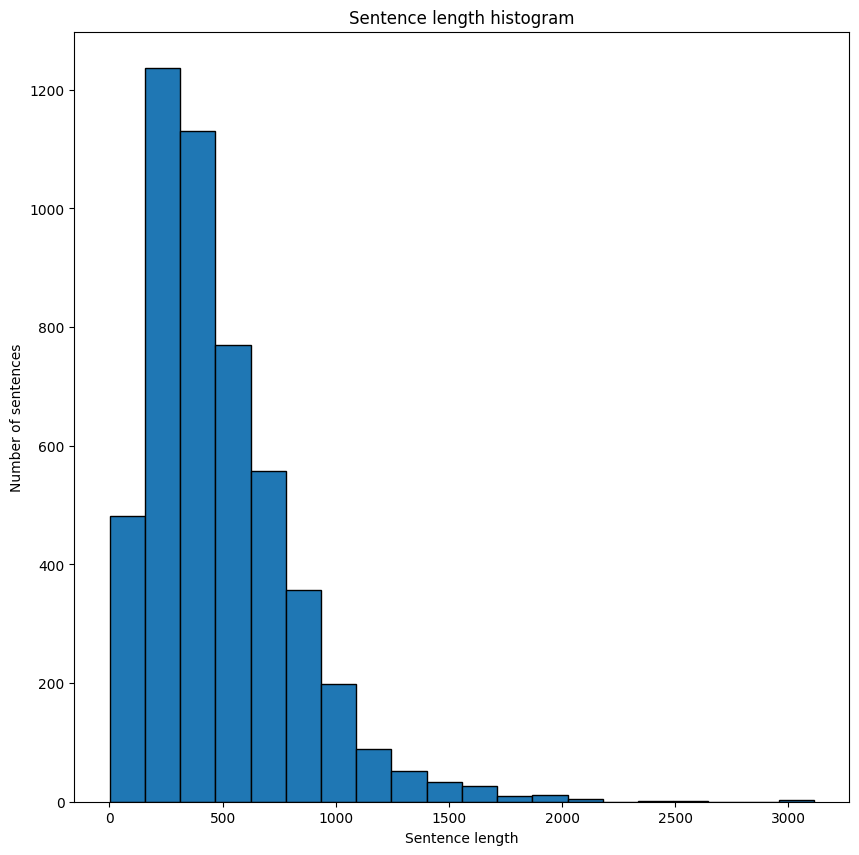

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.title('Sentence length histogram')
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths, edgecolor = 'black', bins = 20)
plt.show()

In [ ]:
print(f"Median sentence length {np.median(sentence_lengths)}")
print(f"Mean sentence length {round(np.mean(sentence_lengths), 2)}")

Median sentence length 421.5
Mean sentence length 487.5
